In [4]:
# Installs required for gym animation
!pip install pyvirtualdisplay
!sudo apt-get install xvfb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [5]:
# Imports
import gym
import tensorflow as tf
from tensorflow.keras import layers
from copy import copy
import numpy as np
import matplotlib.pyplot as plt

# Gym display imports
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path
import random, os.path, glob, csv, base64, itertools, sys
from gym.wrappers import Monitor

In [7]:
# DDGP Agent and related code based on code in a Keras tutorial https://keras.io/examples/rl/ddpg_pendulum/

class Replay_Buffer:
    def __init__(self, number_states, number_actions, buffer_capacity=100000, batch_size=64, minimum_buffer_size=400):

        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        self.minimum_buffer_size = minimum_buffer_size
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, number_states))
        self.action_buffer = np.zeros((self.buffer_capacity, number_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, number_states))

    def add_observation(self, obs_tuple):
        # Takes (s,a,r,s') obervation tuple as input
        
        # Set index to zero if buffer_capacity is exceeded, replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    def check_buffer_size(self):
        return self.buffer_counter >= self.batch_size and self.buffer_counter >= self.minimum_buffer_size

    def get_batch(self):

        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])    

        return state_batch, action_batch, reward_batch, next_state_batch  

def get_actor(number_states, actions_upper_bound):
    # Initialize weights between -3e-3 and 3-e3

    # Note: We need the initialization for last layer of the Actor to be between -0.003 and 0.003 
    # as this prevents us from getting 1 or -1 output values in the initial stages, 
    # which would squash our gradients to zero, as we use the tanh activation.

    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(number_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    outputs = outputs * actions_upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(number_states, number_actions):
    # State as input
    state_input = layers.Input(shape=(number_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(number_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

@tf.function
def update_target_weights(target_weights, weights, tau):

    # Update the weights of the target model.
    # We update the models' weights as a weighted average between the target weights and the trained networks’ weights.
    # We are using tau as the weight given to the trained networks’ weights. 
    # Given the low value of tau, we’re doing a “soft” update.

    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

class DDPG_Agent():
    def __init__ (self, 
                  observation_space, 
                  action_space, 
                  std_dev=0.2, 
                  gamma = 0.99, 
                  tau = 0.005, 
                  actor_learning_rate = 0.002, 
                  critic_learning_rate = 0.001):

        self.gamma = gamma
        self.std_dev = std_dev
        self.tau = tau

        self.number_states = observation_space.shape[0]
        self.number_actions = action_space.shape[0]
        self.actions_upper_bound = action_space.high[0]
        self.actions_lower_bound = action_space.low[0]
        self.noise = np.zeros(self.number_actions)

        # Create the experience replay buffer
        self.experience_replay = Replay_Buffer(self.number_states, self.number_actions)

        # Create the actor and critic models
        self.actor_model = get_actor(self.number_states, self.actions_upper_bound)
        self.critic_model = get_critic(self.number_states, self.number_actions)

        # Create the actor and critic targets
        self.target_actor = get_actor(self.number_states, self.actions_upper_bound)
        self.target_critic = get_critic(self.number_states, self.number_actions)

        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())

        # Learning rate for actor-critic models
        self.critic_learning_rate = critic_learning_rate
        self.actor_learning_rate = actor_learning_rate

        # Create the optimisers for the actor and critics
        self.critic_optimizer = tf.keras.optimizers.Adam(self.critic_learning_rate)
        self.actor_optimizer = tf.keras.optimizers.Adam(self.actor_learning_rate)

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch):
         
        with tf.GradientTape() as tape:

            # Calculate the Critic loss 

            # This is computed as the Mean Squared Error of y - Q(s, a) where y is the expected return as seen by the Target Critic model, 
            # and Q(s, a) is action value predicted by the Critic model. 
            # y is a moving target that the Critic Model tries to achieve; we make this target stable by updating the Target Critic model slowly.

            # Feed the experience replay batch states to the target actor model for training
            target_actions = self.target_actor(next_state_batch, training=True)

            # Calculate y as the expected return as seen by the target actor network
            y = reward_batch + self.gamma * self.target_critic([next_state_batch, target_actions], training=True)

            # Calculate the critic's Q(s,a) as the action value predicted by the critic model 
            # trained using the experience replay's state and action batch
            critic_value = self.critic_model([state_batch, action_batch], training=True)

            # Calculate the critic loss as the mean squared error of y - Q(s,a) 
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        # Update the Critic Model
        critic_gradients = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_gradients, self.critic_model.trainable_variables))

        with tf.GradientTape() as tape:

            # Calculate the Actor loss

            # This is computed using the mean of the value given by the Critic Model for the actions 
            # taken by the Actor Model. We seek to maximize this quantity.
            # Hence we update the Actor Model so that it produces actions that get the maximum predicted value 
            # as seen by the Critic Model, for a given state.

            # Get actions from the Actor Model for the given batch of states from experience replay 
            actions = self.actor_model(state_batch, training=True)

            # Calculate the critic model's Q-value for the given batch of states and actions
            critic_value = self.critic_model([state_batch, actions], training=True)

            # Calculate the actor loss as the mean of the critic Q-values
            actor_loss = -tf.math.reduce_mean(critic_value)

        # Update the Actor Model 
        actor_gradients = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_gradients, self.actor_model.trainable_variables))

    def learn(self):

        # Check whether we have sufficient entries in the replay buffer before trying to learn from it
        if self.experience_replay.check_buffer_size() == True:
            
            # Get a mini-batch from experience replay
            state_batch, action_batch, reward_batch, next_state_batch = self.experience_replay.get_batch()

            # Update based on the provided experience replay mini-batch sample
            self.update(state_batch, action_batch, reward_batch, next_state_batch)

    def get_actions_for_tfbatch(self, tf_states, evaluation = False):

        # Get sampled actions from the actor model for the provided batched states in tensorflow format
        sampled_actions = self.actor_model(tf_states, training=False)

        return sampled_actions

    def get_action(self, state, evaluation = False):
        # Get the action for the given state and add exploratory noise if we are in evaluation mode.

        # Convert the state to a tensorflow tensor
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)

        # Get sampled actions from the actor model
        sampled_actions = tf.squeeze(self.actor_model(tf_state))

        # Convert sampled actions to a numpy array
        sampled_actions = sampled_actions.numpy()   
        
        if not evaluation:
            # If we are not in evaluation mode, ie in training mode, add exploration noise to action 
            self.noise = self._ornstein_uhlenbeck_process(self.noise)
            sampled_actions += self.noise

        # We make sure action is within bounds
        bounded_action = np.clip(sampled_actions, self.actions_lower_bound, self.actions_upper_bound)

        return [np.squeeze(bounded_action)]    

    def update_target_models(self):
        # The target models are updated very slowing using a small learning rate of tau.
        # The purpose of the target models is to add stability to training.
        # We are learning from estimated targets and the Target models are updated slowly, hence keeping our estimated targets stable.
        
        # Update the target actor model weights
        update_target_weights(self.target_actor.variables, self.actor_model.variables, self.tau)

        # Update the target critic model weights
        update_target_weights(self.target_critic.variables, self.critic_model.variables, self.tau)   

    def _ornstein_uhlenbeck_process(self, x, theta=0.15, mu=0, dt=1e-2, std=0.2):
        
        # Ornstein–Uhlenbeck process
        ou = x + theta * (mu-x) * dt + std * np.sqrt(dt) * np.random.normal(size=self.number_actions)
        
        return ou

    def add_to_replay_buffer(self, state, action, reward, new_state):
        self.experience_replay.add_observation((state, action, reward, new_state))

    def train(self, environment, number_episodes, verbose = False):

        episodic_reward_history = []

        for episode in range(number_episodes):

            # Reset the environment
            state = environment.reset()

            # Initialisations
            episodic_reward = 0

            while True:

                # Get the action based on the current state.  As we are training we set
                # evaluation=False so that exploration noise is not added to the action.
                action = self.get_action(state = state, evaluation = False)

                # Receive state and reward from environment.
                next_state, reward, done, info = environment.step(action)

                # Add to experience replay buffer
                self.add_to_replay_buffer(state, action, reward, next_state)

                # Accumulate episodic reward
                episodic_reward += reward

                # Learn
                self.learn()

                # Update targets
                self.update_target_models()

                # End this episode when done
                if done:
                    break

                # Set the state to the next state
                state = next_state

            # Add the episode reward to the history
            episodic_reward_history.append(episodic_reward)

            if verbose == True:
                # Print the results
                print("Episode:", episode, "Average episodic rewards over last 5 episodes:", np.mean(episodic_reward_history[-5:]))

        return episodic_reward_history

In [8]:
# Set static variables
ENVIRONMENT = gym.make("Pendulum-v0")
TOTAL_EPISODES = 60

In [9]:
# Train the supervisor policy using a DDPG algorithm

Supervisor_Policy = DDPG_Agent(ENVIRONMENT.observation_space, ENVIRONMENT.action_space)
ddpg_episodic_rewards_training = Supervisor_Policy.train(ENVIRONMENT, TOTAL_EPISODES, verbose=True)


Episode: 0 Average episodic rewards over last 5 episodes: -1288.4185313938447
Episode: 1 Average episodic rewards over last 5 episodes: -1121.6359786328717
Episode: 2 Average episodic rewards over last 5 episodes: -1182.1371842372419
Episode: 3 Average episodic rewards over last 5 episodes: -1239.5888778535543
Episode: 4 Average episodic rewards over last 5 episodes: -1366.4558002097144
Episode: 5 Average episodic rewards over last 5 episodes: -1474.96325099478
Episode: 6 Average episodic rewards over last 5 episodes: -1652.9507752895745
Episode: 7 Average episodic rewards over last 5 episodes: -1639.7000180645439
Episode: 8 Average episodic rewards over last 5 episodes: -1636.2037932810053
Episode: 9 Average episodic rewards over last 5 episodes: -1490.8761815640094
Episode: 10 Average episodic rewards over last 5 episodes: -1353.493409234077
Episode: 11 Average episodic rewards over last 5 episodes: -1140.854752777624
Episode: 12 Average episodic rewards over last 5 episodes: -1023.4

Average reward per episode over last 10 episodes: -212.16582692750399 



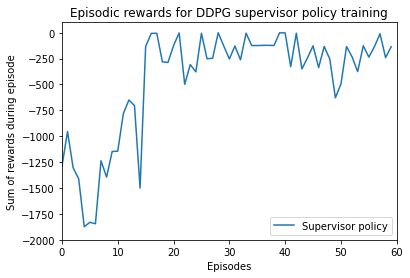

In [10]:
# Present results of DDPG_Policy training 

plt.plot(np.arange(TOTAL_EPISODES), ddpg_episodic_rewards_training[-TOTAL_EPISODES:], label='Supervisor policy')
plt.ylim(-2000, 100)
plt.xlim(0, TOTAL_EPISODES)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('Episodic rewards for DDPG supervisor policy training')
plt.legend()

print("Average reward per episode over last", 10, "episodes:", np.mean(ddpg_episodic_rewards_training[-10:]), "\n")

In [11]:
# ANIMATION OF PENDULUM ENVIRONMENT USING POLICY GENERATED BY DDPG

# Remove any existing videos
!rm ./ddpg_results/*.* 

# Run the environment using the DDPG policy to show animation
# Create the Pendulum-v0 environment
env = gym.make("Pendulum-v0")

# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./ddpg_results", force=True, video_callable=lambda episode: True)

# Set the display details for the animations
display = Display()
display.start();

# Set the policy to be the policy created implicitly by the sarsa_0_estimator
policy = Supervisor_Policy

# Run an episode
done = False
state = env.reset()
while not done:
    action = policy.get_action(state, True)
    state, reward, done, info = env.step([action])

env.close()

# Show the animation
html = []
for mp4 in Path("./ddpg_results").glob("*.mp4"):
    video_b64 = base64.b64encode(mp4.read_bytes())
    html.append('''<video alt="{}" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{}" type="video/mp4" />
              </video>'''.format(mp4, video_b64.decode('ascii')))

ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

rm: cannot remove './ddpg_results/*.*': No such file or directory


In [18]:
class DDPG_Supervised_Agent():
    def __init__ (self, 
                  supervisor, 
                  observation_space, 
                  action_space, 
                  std_dev=0.2, 
                  gamma = 0.99, 
                  tau = 0.005, 
                  actor_learning_rate = 
                  0.002, 
                  critic_learning_rate = 0.001,
                  k_value = 1,
                  k_decay_value = 0.99,
                  k_minimum = 0.001,
                  pioneer_buffer_threshold = -200,
                  pioneer_buffer_maximum = 100,
                  noise_decay_rate = 0.9999):

        self.gamma = gamma
        self.std_dev = std_dev
        self.tau = tau
        self.supervisor = supervisor
        self.number_states = observation_space.shape[0]
        self.number_actions = action_space.shape[0]
        self.actions_upper_bound = action_space.high[0]
        self.actions_lower_bound = action_space.low[0]
        self.k = k_value
        self.k_decay_rate = k_decay_value
        self.k_minimum = k_minimum
        self.pioneer_buffer_threshold = pioneer_buffer_threshold
        self.pioneer_buffer_maximum = pioneer_buffer_maximum
        self.noise_decay_rate = noise_decay_rate

        # Initialise the noise
        self.noise = np.zeros(self.number_actions)
        self.noise = self._ornstein_uhlenbeck_process(self.noise)
        self.noise_rate = 1

        # LEARNER
        self.learner_replay_buffer = Replay_Buffer(self.number_states, self.number_actions)
        self.learner_model = get_actor(self.number_states, self.actions_upper_bound)
        self.target_learner = get_actor(self.number_states, self.actions_upper_bound)
        self.target_learner.set_weights(self.learner_model.get_weights())
        self.learner_learning_rate = actor_learning_rate
        self.learner_optimizer = tf.keras.optimizers.Adam(self.learner_learning_rate)

        # CRITIC
        self.critic_model = get_critic(self.number_states, self.number_actions)
        self.target_critic = get_critic(self.number_states, self.number_actions)
        self.target_critic.set_weights(self.critic_model.get_weights())
        self.critic_learning_rate = critic_learning_rate
        self.critic_optimizer = tf.keras.optimizers.Adam(self.critic_learning_rate)

        # PIONEER
        self.pioneer_replay_buffer = Replay_Buffer(self.number_states, self.number_actions)
        self.pioneer_model = get_actor(self.number_states, self.actions_upper_bound)
        self.pioneer_learning_rate = actor_learning_rate
        self.pioneer_optimizer = tf.keras.optimizers.Adam(self.learner_learning_rate)      

    def add_to_episodic_replay_buffer(self, state, action, reward, new_state):
        self.episodic_replay_buffer.add_observation((state, action, reward, new_state))

    def initialise_episodic_buffer(self):
        # Initialise the episodic replay buffer by creating a new version of it
        self.episodic_replay_buffer = Replay_Buffer(self.number_states, self.number_actions)

    def add_to_pioneer_replay_buffer(self, state, action, reward, new_state):
        self.pioneer_replay_buffer.add_observation((state, action, reward, new_state))

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def learner_update(self, state_batch, action_batch, reward_batch, next_state_batch):
         
        with tf.GradientTape() as tape:

            # Calculate the Critic loss 

            # This is computed as the Mean Squared Error of y - Q(s, a) where y is the expected return as seen by the Target Critic model, 
            # and Q(s, a) is action value predicted by the Critic model. 
            # y is a moving target that the Critic Model tries to achieve; we make this target stable by updating the Target Critic model slowly.

            # Feed the experience replay batch states to the target actor model for training
            target_actions = self.target_learner(next_state_batch, training=True)

            # Calculate y as the expected return as seen by the target actor network
            y = reward_batch + self.gamma * self.target_critic([next_state_batch, target_actions], training=True)

            # Calculate the critic's Q(s,a) as the action value predicted by the critic model 
            # trained using the experience replay's state and action batch
            critic_value = self.critic_model([state_batch, action_batch], training=True)

            # Calculate the critic loss as the mean squared error of y - Q(s,a) 
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        # Update the Critic Model
        critic_gradients = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_gradients, self.critic_model.trainable_variables))

        with tf.GradientTape() as tape:

            # Calculate the learner loss

            # This is computed using the mean of the value given by the Critic Model for the actions 
            # taken by the learner Model. We seek to maximize this quantity.
            # Hence we update the Actor Model so that it produces actions that get the maximum predicted value 
            # as seen by the Critic Model, for a given state.

            # Get actions from the Learner Model for the given batch of states from experience replay 
            actions = self.learner_model(state_batch, training=True)

            # Calculate the critic model's Q-value for the given batch of states and actions
            critic_value = self.critic_model([state_batch, actions], training=True)

            # Get actions from the supervisor model for the given batch of states from experience replay
            supervisor_actions = self.supervisor.get_actions_for_tfbatch(state_batch, evaluation=True)

            # Calculate the actor loss as the mean of the critic Q-values
            learner_loss = - tf.math.reduce_mean(critic_value)

            # Calculate the actor loss as the mean of the squared error of the actor values and supervisor values
            supervised_loss = tf.math.divide(tf.math.reduce_mean(tf.math.square(actions - supervisor_actions)),2)

            # Calculate the combined loss of the learner and the supervisor
            combined_loss = (1 - self.k) * learner_loss + self.k * supervised_loss

        # Update the Learner Model 
        combined_gradients = tape.gradient(combined_loss, self.learner_model.trainable_variables)
        self.learner_optimizer.apply_gradients(zip(combined_gradients, self.learner_model.trainable_variables))

    def learner_learn(self):

        # Check whether we have sufficient entries in the replay buffer before trying to learn from it
        if self.learner_replay_buffer.check_buffer_size() == True:
            
            # Get a mini-batch from experience replay
            state_batch, action_batch, reward_batch, next_state_batch = self.learner_replay_buffer.get_batch()

            # Update based on the provided experience replay mini-batch sample
            self.learner_update(state_batch, action_batch, reward_batch, next_state_batch)

    @tf.function
    def pioneer_update(self, state_batch, action_batch, reward_batch, next_state_batch):
         
        with tf.GradientTape() as tape:

            # Get actions from the Pioneer Model for the given batch of states from experience replay 
            pioneer_actions = self.pioneer_model(state_batch, training=True)

            # Get the actions from the learner policy
            learner_actions = self.learner_model.evaluate(state_batch)

            # Calculate the pioneer loss as the mean of the squared error of the pioneer values and learner values
            pioneer_loss = tf.math.divide(tf.math.reduce_mean(tf.math.square(self.pioneer_actions - self.learner_actions)),2)

        # Update the Pioneer Model 
        pioneer_gradients = tape.gradient(pioneer_loss, self.learner_model.trainable_variables)
        self.learner_optimizer.apply_gradients(zip(pioneer_gradients, self.pioneer_model.trainable_variables))

    def pioneer_learn(self):

        # Check whether we have sufficient entries in the replay buffer before trying to learn from it
        if self.pioneer_replay_buffer.check_buffer_size() == True:
            
            # Get a mini-batch from experience replay
            state_batch, action_batch, reward_batch, next_state_batch = self.pioneer_replay_buffer.get_batch()

            # Update based on the provided experience replay mini-batch sample
            self.pioneer_update(state_batch, action_batch, reward_batch, next_state_batch)

    def get_action(self, state, evaluation = False):
        # Get the action for the given state and add exploratory noise if we are in evaluation mode.
        # The returned action will be a combined action based on the learner and the supervisor policies.

        # Convert the state to a tensorflow tensor
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)

        # Get sampled actions from the learner model
        sampled_actions = tf.squeeze(self.learner_model(tf_state))

        # Convert sampled actions to a numpy array
        sampled_actions = sampled_actions.numpy()   

        if not evaluation:
            # If we are not in evaluation mode, ie in training mode, add exploration noise to action 
            # self.noise = self._ornstein_uhlenbeck_process(self.noise)
            sampled_actions += self.noise        

        # We make sure action is within bounds
        bounded_action = np.clip(sampled_actions, self.actions_lower_bound, self.actions_upper_bound)

        learner_action = [np.squeeze(bounded_action)]

        # Combine the learner action and the supervisor action
        supervisor_action = self.supervisor.get_action(state, evaluation = True)  

        combined_action = self.k * supervisor_action[0] + (1 - self.k) * learner_action[0]

        return [combined_action] 

    def update_target_models(self):
        # The target models are updated very slowing using a small learning rate of tau.
        # The purpose of the target models is to add stability to training.
        # We are learning from estimated targets and the Target models are updated slowly, hence keeping our estimated targets stable.
        
        # Update the target actor model weights
        update_target_weights(self.target_learner.variables, self.learner_model.variables, self.tau)

        # Update the target critic model weights
        update_target_weights(self.target_critic.variables, self.critic_model.variables, self.tau)   

    def _ornstein_uhlenbeck_process(self, x, theta=0.15, mu=0, dt=1e-2, std=0.2):
        
        # Ornstein–Uhlenbeck process
        ou = x + theta * (mu-x) * dt + std * np.sqrt(dt) * np.random.normal(size=self.number_actions)
        
        return ou

    def decay_noise(self, number_episodes):
        self.noise *= self.noise_decay_rate

    def add_to_learner_replay_buffer(self, state, action, reward, new_state):
        self.learner_replay_buffer.add_observation((state, action, reward, new_state))

    def copy_learner_to_pioneer(self):

        # Copy the pioneer model to the learner model
        self.pioneer_model.set_weights(self.learner_model.get_weights()) 

    def copy_pioneer_to_learner(self):

        # Copy the learner model to the pioneer model
        self.pioneer_model.set_weights(self.learner_model.get_weights()) 

    def train(self, environment, number_episodes, verbose = False, use_pioneer=True):

        episodic_reward_history = []

        for episode in range(number_episodes):

            # Reset the environment
            state = environment.reset()

            # Initialisations
            episodic_reward = 0
            self.initialise_episodic_buffer()

            while True:

                # Get the action based on the current state.  As we are training we set
                # evaluation=False so that exploration noise is not added to the action.
                action = self.get_action(state = state, evaluation = False)

                # Receive state and reward from environment.
                next_state, reward, done, info = environment.step(action)

                # Add to learner replay buffer
                self.add_to_learner_replay_buffer(state, action, reward, next_state)

                # Add to episodic replay buffer
                self.add_to_episodic_replay_buffer(state, action, reward, next_state)

                # Accumulate episodic reward
                episodic_reward += reward

                # Learn
                self.learner_learn()

                # Update targets
                self.update_target_models()

                # End this episode when done
                if done:
                    break

                # Set the state to the next state
                state = next_state

            # Add the episode reward to the history
            episodic_reward_history.append(episodic_reward)

            if verbose == True:
                # Print the results
                print("Episode:", episode, "Average episodic rewards over last 5 episodes:", np.mean(episodic_reward_history[-5:]), ", k:", self.k)

            if use_pioneer:
                if episodic_reward > self.pioneer_buffer_threshold:
                    
                    # Add to episodic pioneer buffer
                    self.add_to_pioneer_replay_buffer(state, action, reward, next_state)
                
                # Copy the learner model to the pioneer model
                self.copy_learner_to_pioneer()

                # Pioneer learning
                self.pioneer_learn()

                # Empty the episodic replay buffer (not necessary as re-initialising it at the start of each episode)

            # Check if target score is achieved.  If so, decay k value

            # In the algorithm they refer to some target score being the cause of k to be reduced however
            # further in the experiments part they say that k is reduced by 10% every 5 episodes.

            # Decay the k value for each episode for pendulum-v0.  This could be changed to every x number of episodes.
            k_reduced = False

            if self.k >= self.k_minimum:
                self.k = self.k * self.k_decay_rate ** episode
                k_reduced = True
            else:
                # As the k value has gone below the minimum k value, set it to 0
                self.k = 0.0

            if k_reduced:

                # Set the learner to be the pioneer 
                if use_pioneer:
                    self.copy_pioneer_to_learner()

                    # Increase the pioneer buffer threshold
                    if self.pioneer_buffer_threshold <= self.pioneer_buffer_maximum:
                        self.pioneer_buffer_threshold += 1

        return episodic_reward_history


In [19]:
# Supervised RL

Supervised_Combined_Policy = DDPG_Supervised_Agent(Supervisor_Policy, ENVIRONMENT.observation_space, ENVIRONMENT.action_space, k_value=1)
ddpg_supervised_episodic_rewards_training = Supervised_Combined_Policy.train(ENVIRONMENT, TOTAL_EPISODES, verbose=True)


Episode: 0 Average episodic rewards over last 5 episodes: -132.65089559201 , k: 1
Episode: 1 Average episodic rewards over last 5 episodes: -181.43526938895542 , k: 1.0
Episode: 2 Average episodic rewards over last 5 episodes: -204.19789909053506 , k: 0.99
Episode: 3 Average episodic rewards over last 5 episodes: -184.7145998203085 , k: 0.9702989999999999
Episode: 4 Average episodic rewards over last 5 episodes: -196.8744777122085 , k: 0.9414801494009999
Episode: 5 Average episodic rewards over last 5 episodes: -196.94281075947833 , k: 0.9043820750088043
Episode: 6 Average episodic rewards over last 5 episodes: -176.16252221094064 , k: 0.8600583546412882
Episode: 7 Average episodic rewards over last 5 episodes: -151.7086053642053 , k: 0.8097278682212583
Episode: 8 Average episodic rewards over last 5 episodes: -151.46433090474784 , k: 0.7547192872036325
Episode: 9 Average episodic rewards over last 5 episodes: -104.65844857274094 , k: 0.6964132180495735
Episode: 10 Average episodic rew

In [20]:
# Unsupervised RL

Unsupervised_Policy = DDPG_Supervised_Agent(Supervisor_Policy, ENVIRONMENT.observation_space, ENVIRONMENT.action_space, k_value=0)
ddpg_unsupervised_episodic_rewards_training = Unsupervised_Policy.train(ENVIRONMENT, TOTAL_EPISODES, verbose=True)


Episode: 0 Average episodic rewards over last 5 episodes: -1069.7574923789057 , k: 0
Episode: 1 Average episodic rewards over last 5 episodes: -914.8024799782747 , k: 0.0
Episode: 2 Average episodic rewards over last 5 episodes: -1108.9846356307387 , k: 0.0
Episode: 3 Average episodic rewards over last 5 episodes: -1172.6779848430854 , k: 0.0
Episode: 4 Average episodic rewards over last 5 episodes: -1275.1495256872847 , k: 0.0
Episode: 5 Average episodic rewards over last 5 episodes: -1384.617216928697 , k: 0.0
Episode: 6 Average episodic rewards over last 5 episodes: -1562.466235628845 , k: 0.0
Episode: 7 Average episodic rewards over last 5 episodes: -1580.3251764775603 , k: 0.0
Episode: 8 Average episodic rewards over last 5 episodes: -1619.0024883880094 , k: 0.0
Episode: 9 Average episodic rewards over last 5 episodes: -1614.8158962570626 , k: 0.0
Episode: 10 Average episodic rewards over last 5 episodes: -1567.9652329663445 , k: 0.0
Episode: 11 Average episodic rewards over last 

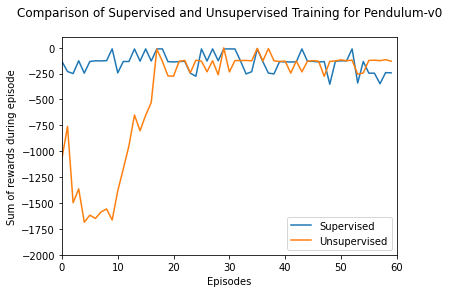

In [21]:
# Present results of comparison between supervised and unsupervised 

plt.plot(np.arange(TOTAL_EPISODES), ddpg_supervised_episodic_rewards_training[-TOTAL_EPISODES:], label='Supervised')
plt.plot(np.arange(TOTAL_EPISODES), ddpg_unsupervised_episodic_rewards_training[-TOTAL_EPISODES:], label='Unsupervised')
plt.ylim(-2000, 100)
plt.xlim(0, TOTAL_EPISODES)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('Comparison of Supervised and Unsupervised Training for Pendulum-v0\n')
plt.legend()

In [30]:
# Train a bad supervisor - only train for 14 episodes so it as not fully converged

Bad_Supervisor_Policy = DDPG_Agent(ENVIRONMENT.observation_space, ENVIRONMENT.action_space)
bad_ddpg_episodic_rewards_training = Bad_Supervisor_Policy.train(ENVIRONMENT, 17, verbose=True)


Episode: 0 Average episodic rewards over last 5 episodes: -1800.6585742284265
Episode: 1 Average episodic rewards over last 5 episodes: -1309.8357087527795
Episode: 2 Average episodic rewards over last 5 episodes: -1339.6413373235653
Episode: 3 Average episodic rewards over last 5 episodes: -1334.2793492434469
Episode: 4 Average episodic rewards over last 5 episodes: -1336.1776556866905
Episode: 5 Average episodic rewards over last 5 episodes: -1256.9689548173344
Episode: 6 Average episodic rewards over last 5 episodes: -1336.8697237443332
Episode: 7 Average episodic rewards over last 5 episodes: -1338.9638569937595
Episode: 8 Average episodic rewards over last 5 episodes: -1395.0341514008985
Episode: 9 Average episodic rewards over last 5 episodes: -1406.757262311999
Episode: 10 Average episodic rewards over last 5 episodes: -1356.725482172346
Episode: 11 Average episodic rewards over last 5 episodes: -1324.4211077348816
Episode: 12 Average episodic rewards over last 5 episodes: -1311

In [31]:
# Supervised RL with bad supervisor

Badly_Supervised_Policy = DDPG_Supervised_Agent(Bad_Supervisor_Policy, ENVIRONMENT.observation_space, ENVIRONMENT.action_space, k_value=1)
bad_ddpg_supervised_episodic_rewards_training = Badly_Supervised_Policy.train(ENVIRONMENT, TOTAL_EPISODES, verbose=False)


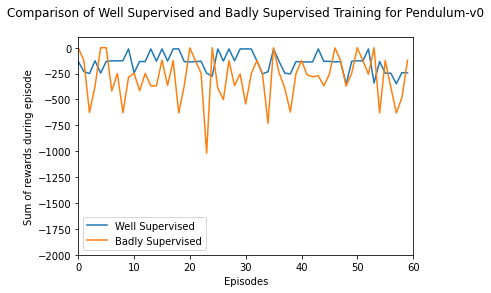

In [32]:
# Present results of comparison between good supervisor and bad supervisor

plt.plot(np.arange(TOTAL_EPISODES), ddpg_supervised_episodic_rewards_training[-TOTAL_EPISODES:], label='Well Supervised')
plt.plot(np.arange(TOTAL_EPISODES), bad_ddpg_supervised_episodic_rewards_training[-TOTAL_EPISODES:], label='Badly Supervised')
plt.ylim(-2000, 100)
plt.xlim(0, TOTAL_EPISODES)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('Comparison of Well Supervised and Badly Supervised Training for Pendulum-v0\n')
plt.legend()

In [25]:
# Supervised RL with no pioneer

Pioneerless_Supervised_Policy = DDPG_Supervised_Agent(Supervisor_Policy, ENVIRONMENT.observation_space, ENVIRONMENT.action_space, k_value=1)
pioneerless_ddpg_supervised_episodic_rewards_training = Pioneerless_Supervised_Policy.train(ENVIRONMENT, TOTAL_EPISODES, verbose=False, use_pioneer=False)


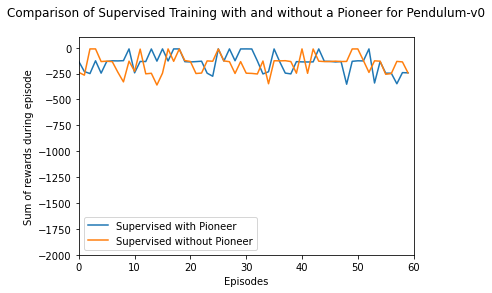

In [26]:
# Present results of comparison between supervisor with and without pioneer policy

plt.plot(np.arange(TOTAL_EPISODES), ddpg_supervised_episodic_rewards_training[-TOTAL_EPISODES:], label='Supervised with Pioneer')
plt.plot(np.arange(TOTAL_EPISODES), pioneerless_ddpg_supervised_episodic_rewards_training[-TOTAL_EPISODES:], label='Supervised without Pioneer')
plt.ylim(-2000, 100)
plt.xlim(0, TOTAL_EPISODES)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('Comparison of Supervised Training with and without a Pioneer for Pendulum-v0\n')
plt.legend()